# MANUFACTURING - MODEL 2 - Simple lagged RF, no lat/long info

The goal hear is to have the simplest random forest using 1-year lag and all the variables constructed on the day 1. 

*I ignore the spatial aspect here to construct an example, will add soon*

## Initialise
### Imports

In [1]:
import time
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# impute NaN with the median of its country, to improve
class NUTSImputer(BaseEstimator, TransformerMixin):
    def __init__(self, nuts_id_column, strategy='mean'):
        self.nuts_id_column = nuts_id_column
        self.strategy = strategy
        self.impute_values = {}

    def fit(self, X, y=None):
        # Check if the NUTS_ID column exists
        if self.nuts_id_column not in X.columns:
            raise ValueError(f"{self.nuts_id_column} column not found in the DataFrame")

        # Compute imputation values for each group
        for nuts_id in X[self.nuts_id_column].unique():
            nuts_prefix = nuts_id[:2]
            filter_rows = X[self.nuts_id_column].str.startswith(nuts_prefix)

            if self.strategy == 'mean':
                self.impute_values[nuts_prefix] = X[filter_rows].mean()
            # Additional strategies can be implemented here

        return self

    def transform(self, X):
        # Ensure that X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        X_transformed = X.copy()
        for nuts_prefix, impute_value in self.impute_values.items():
            filter_rows = X[self.nuts_id_column].str.startswith(nuts_prefix)
            X_transformed.loc[filter_rows] = X_transformed[filter_rows].fillna(impute_value)

        return X_transformed

### Constants

In [3]:
ECON_DATA = "ind-v.csv"
CLIM_DATA = "final_dataset_reduced-v.csv"
CLIM_COLS = ["year", "NUTS_ID", 'hwi_sum','hwi_sum_lag','interacted_hwi_spi01','interacted_hwi_spi03','interacted_hwi_spi12','lfi_count_y','n_sma','n_sma_lag','spi_01_max','spi_03_max','spi_06_max','SPI_12_max','tmax_mean']

TARGET = "C_Gva_perc"  # A for Agriculture, C for manufaCtoring 
# which columns to drop, e.g. here the other target variables, time, nuts name, and index
DROP_COLS = ["year", "NUTS_ID"] # spatiotemp coords

LAG_CLIM_COLS = ["n_sma", "hwi_sum"]  # which cols to lag
MIN_YEAR_TRAIN = 2003  # for ex. to eliminated lagged NA
MAX_YEAR_TRAIN = 2018
MIN_YEAR_VALID = 2019
MAX_YEAR_VALID = 2021

### Load dataset

In [4]:
econ_df = pd.read_csv(ECON_DATA, index_col=0)
econ_df

NUTS_ID  year  G-J_Gva_perc  Gva_Energ_perc  A_Gva_perc  pop_perc  \
0       AT111  2002           NaN             NaN         NaN       NaN   
1       AT111  2003      0.103774        0.360000    0.486486 -0.002120   
2       AT111  2004     -0.008547       -0.205882   -0.181818 -0.001859   
3       AT111  2005     -0.025862       -0.037037   -0.244444 -0.003459   
4       AT111  2006      0.088496       -0.038462    0.088235  0.000000   
...       ...   ...           ...             ...         ...       ...   
26497   BE32C  2012           NaN             NaN         NaN       NaN   
26498   BE32D  2009           NaN             NaN         NaN       NaN   
26499   BE32D  2010           NaN             NaN         NaN       NaN   
26500   BE32D  2011           NaN             NaN         NaN       NaN   
26501   BE32D  2012           NaN             NaN         NaN       NaN   

       C_emp_perc  C_Gva_perc  
0             NaN         NaN  
1        0.000000    0.032609  
2        0.045455   -0.031579  
3       -0.043478    0.195652  
4        0.045455    0.009091  
...           ...         ...  
26497   -0.045455         NaN  
26498   -0.052632         NaN  
26499    0.000000         NaN  
26500    0.055556         NaN  
26501    0.000000         NaN  

[26502 rows x 8 columns]

In [5]:
clim_df = pd.read_csv(CLIM_DATA, index_col=0)
# lag and filter
for lagcol in LAG_CLIM_COLS:
    clim_df[f"{lagcol}_lag"] = clim_df[lagcol].shift(1)
clim_df = clim_df[CLIM_COLS]
clim_df

year NUTS_ID    hwi_sum  hwi_sum_lag  interacted_hwi_spi01  \
0      2002   AT111  17.450511          NaN             27.912092   
1      2003   AT111  10.337299    17.450511              6.621040   
2      2004   AT111   5.598158    10.337299              8.912268   
3      2005   AT111   1.529521     5.598158              2.211688   
4      2006   AT111   9.340811     1.529521             15.118102   
...     ...     ...        ...          ...                   ...   
25300  2017   SK042   6.603099     5.616843             10.733337   
25301  2018   SK042   5.230994     6.603099              5.484697   
25302  2019   SK042  45.962998     5.230994             72.276814   
25303  2020   SK042        NaN    45.962998                   NaN   
25304  2021   SK042  10.214574          NaN                   NaN   

       interacted_hwi_spi03  interacted_hwi_spi12  lfi_count_y  n_sma  \
0                 24.997857              5.505636          0.0    7.0   
1                  7.091387              7.034532          0.0    1.0   
2                  8.388840              1.978949          0.0    0.0   
3                  2.126800              0.984247          0.0    0.0   
4                 11.918875             15.244203          0.0    3.0   
...                     ...                   ...          ...    ...   
25300              8.874565              4.889595          2.0    0.0   
25301              6.860448              6.033951          5.0    2.0   
25302             53.454967              1.057149          7.0    4.0   
25303                   NaN                   NaN          3.0    0.0   
25304                   NaN                   NaN          0.0    0.0   

       n_sma_lag  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  tmax_mean  
0            NaN      1.5995      1.4325      1.1380      0.3155  14.163750  
1            7.0      0.6405      0.6860      1.6705      0.6805  14.362667  
2            1.0      1.5920      1.4985      1.6150      0.3535  13.233500  
3            0.0      1.4460      1.3905      1.2395      0.6435  12.495500  
4            0.0      1.6185      1.2760      1.2195      1.6320  13.789333  
...          ...         ...         ...         ...         ...        ...  
25300        0.0      1.6255      1.3440      1.1425      0.7405  13.794917  
25301        0.0      1.0485      1.3115      2.0210      1.1535  14.035000  
25302        2.0      1.5725      1.1630      0.5785      0.0230  14.798000  
25303        4.0      1.8240      1.5540      1.7855      1.6385  14.123833  
25304        0.0         NaN         NaN         NaN         NaN        NaN  

[22420 rows x 15 columns]

In [6]:
in_df = pd.merge(econ_df, clim_df, on=['year', 'NUTS_ID'])

#### Basic Exploratory Analysis, to show / complete as needed

In [7]:
print(f"Data shape:\n{in_df.shape}\n")
# print(f"Data Types:\n{in_df.dtypes}\n")
# print(f"Data Range:\n{in_df.describe()}\n")

Data shape:
(22420, 21)



#### Explore missing values

In [8]:
miss_val_in_col = in_df.isna().sum()
miss_val_in_col = miss_val_in_col[miss_val_in_col > 0].sort_values()
frac_miss_val = miss_val_in_col / in_df.shape[0]
miss_df = pd.DataFrame({'Counts of Missing': miss_val_in_col, 'Fractions of Missing': frac_miss_val})
print(f"Missing value counts and fractions by column:\n{miss_df}\n")
print(f"Rows with missing values\n")
in_df[in_df.isna().any(axis=1)]

Missing value counts and fractions by column:
                      Counts of Missing  Fractions of Missing
n_sma_lag                             1              0.000045
spi_01_max                          453              0.020205
spi_06_max                          453              0.020205
spi_03_max                          453              0.020205
SPI_12_max                          453              0.020205
Gva_Energ_perc                     1267              0.056512
pop_perc                           1299              0.057939
G-J_Gva_perc                       1322              0.058965
C_Gva_perc                         1322              0.058965
A_Gva_perc                         1334              0.059500
C_emp_perc                         1946              0.086798
tmax_mean                          3029              0.135103
hwi_sum                            5802              0.258787
hwi_sum_lag                        5803              0.258831
interacted_hwi_spi01    

NUTS_ID  year  G-J_Gva_perc  Gva_Energ_perc  A_Gva_perc  pop_perc  \
0       AT111  2002           NaN             NaN         NaN       NaN   
18      AT111  2020     -0.032895       -0.027778    0.189189 -0.001068   
19      AT112  2002           NaN             NaN         NaN       NaN   
37      AT112  2020     -0.066942        0.039683    0.117647  0.007524   
38      AT113  2002           NaN             NaN         NaN       NaN   
...       ...   ...           ...             ...         ...       ...   
22407   SK042  2009      0.000644       -0.054749   -0.271719  0.002763   
22408   SK042  2010      0.084484       -0.151387   -0.195374  0.003077   
22409   SK042  2011      0.118502        0.074571    0.247324  0.016391   
22418   SK042  2020      0.007832        0.193444   -0.060141  0.001336   
22419   SK042  2021      0.074124       -0.018709    0.132985 -0.025843   

       C_emp_perc  C_Gva_perc    hwi_sum  hwi_sum_lag  ...  \
0             NaN         NaN  17.450511          NaN  ...   
18      -0.043478   -0.039474        NaN    49.921879  ...   
19            NaN         NaN   7.855846          NaN  ...   
37      -0.025316   -0.078652        NaN    56.059412  ...   
38            NaN         NaN  17.673482          NaN  ...   
...           ...         ...        ...          ...  ...   
22407   -0.103029   -0.266388        NaN     2.493420  ...   
22408   -0.073650    0.288411        NaN          NaN  ...   
22409    0.043666    0.016154   1.722158          NaN  ...   
22418   -0.042572   -0.081903        NaN    45.962998  ...   
22419         NaN    0.212912  10.214574          NaN  ...   

       interacted_hwi_spi03  interacted_hwi_spi12  lfi_count_y  n_sma  \
0                 24.997857              5.505636          0.0    7.0   
18                      NaN                   NaN          0.0    1.0   
19                12.439732              4.473904          4.0    4.0   
37                      NaN                   NaN          2.0    2.0   
38                19.705932              1.290164          8.0    9.0   
...                     ...                   ...          ...    ...   
22407                   NaN                   NaN          2.0    0.0   
22408                   NaN                   NaN          0.0    0.0   
22409              2.105338              4.632604          1.0    3.0   
22418                   NaN                   NaN          3.0    0.0   
22419                   NaN                   NaN          0.0    0.0   

       n_sma_lag  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  tmax_mean  
0            NaN      1.5995      1.4325      1.1380      0.3155  14.163750  
18           1.0      1.2230      1.2935      1.0350      0.4890  15.041833  
19           1.0      1.6410      1.5835      1.4125      0.5695  15.782500  
37           1.0      1.4555      1.2400      1.2400      0.7210  16.631417  
38           2.0      1.2920      1.1150      0.8620      0.0730  15.055667  
...          ...         ...         ...         ...         ...        ...  
22407        0.0      1.2660      1.8860      0.4880      0.7440  13.705083  
22408        0.0      2.8445      2.8410      2.6880      3.0600  12.368833  
22409        0.0      1.3700      1.2225      1.0385      2.6900  13.783333  
22418        4.0      1.8240      1.5540      1.7855      1.6385  14.123833  
22419        0.0         NaN         NaN         NaN         NaN        NaN  

[11034 rows x 21 columns]

In [9]:
print(f"Missing value counts by column:\n{in_df.isnull().sum()}\n")
print(f"Rows with missing values\n")
in_df[in_df.isna().any(axis=1)]

Missing value counts by column:
NUTS_ID                    0
year                       0
G-J_Gva_perc            1322
Gva_Energ_perc          1267
A_Gva_perc              1334
pop_perc                1299
C_emp_perc              1946
C_Gva_perc              1322
hwi_sum                 5802
hwi_sum_lag             5803
interacted_hwi_spi01    6036
interacted_hwi_spi03    6036
interacted_hwi_spi12    6036
lfi_count_y                0
n_sma                      0
n_sma_lag                  1
spi_01_max               453
spi_03_max               453
spi_06_max               453
SPI_12_max               453
tmax_mean               3029
dtype: int64

Rows with missing values



NUTS_ID  year  G-J_Gva_perc  Gva_Energ_perc  A_Gva_perc  pop_perc  \
0       AT111  2002           NaN             NaN         NaN       NaN   
18      AT111  2020     -0.032895       -0.027778    0.189189 -0.001068   
19      AT112  2002           NaN             NaN         NaN       NaN   
37      AT112  2020     -0.066942        0.039683    0.117647  0.007524   
38      AT113  2002           NaN             NaN         NaN       NaN   
...       ...   ...           ...             ...         ...       ...   
22407   SK042  2009      0.000644       -0.054749   -0.271719  0.002763   
22408   SK042  2010      0.084484       -0.151387   -0.195374  0.003077   
22409   SK042  2011      0.118502        0.074571    0.247324  0.016391   
22418   SK042  2020      0.007832        0.193444   -0.060141  0.001336   
22419   SK042  2021      0.074124       -0.018709    0.132985 -0.025843   

       C_emp_perc  C_Gva_perc    hwi_sum  hwi_sum_lag  ...  \
0             NaN         NaN  17.450511          NaN  ...   
18      -0.043478   -0.039474        NaN    49.921879  ...   
19            NaN         NaN   7.855846          NaN  ...   
37      -0.025316   -0.078652        NaN    56.059412  ...   
38            NaN         NaN  17.673482          NaN  ...   
...           ...         ...        ...          ...  ...   
22407   -0.103029   -0.266388        NaN     2.493420  ...   
22408   -0.073650    0.288411        NaN          NaN  ...   
22409    0.043666    0.016154   1.722158          NaN  ...   
22418   -0.042572   -0.081903        NaN    45.962998  ...   
22419         NaN    0.212912  10.214574          NaN  ...   

       interacted_hwi_spi03  interacted_hwi_spi12  lfi_count_y  n_sma  \
0                 24.997857              5.505636          0.0    7.0   
18                      NaN                   NaN          0.0    1.0   
19                12.439732              4.473904          4.0    4.0   
37                      NaN                   NaN          2.0    2.0   
38                19.705932              1.290164          8.0    9.0   
...                     ...                   ...          ...    ...   
22407                   NaN                   NaN          2.0    0.0   
22408                   NaN                   NaN          0.0    0.0   
22409              2.105338              4.632604          1.0    3.0   
22418                   NaN                   NaN          3.0    0.0   
22419                   NaN                   NaN          0.0    0.0   

       n_sma_lag  spi_01_max  spi_03_max  spi_06_max  SPI_12_max  tmax_mean  
0            NaN      1.5995      1.4325      1.1380      0.3155  14.163750  
18           1.0      1.2230      1.2935      1.0350      0.4890  15.041833  
19           1.0      1.6410      1.5835      1.4125      0.5695  15.782500  
37           1.0      1.4555      1.2400      1.2400      0.7210  16.631417  
38           2.0      1.2920      1.1150      0.8620      0.0730  15.055667  
...          ...         ...         ...         ...         ...        ...  
22407        0.0      1.2660      1.8860      0.4880      0.7440  13.705083  
22408        0.0      2.8445      2.8410      2.6880      3.0600  12.368833  
22409        0.0      1.3700      1.2225      1.0385      2.6900  13.783333  
22418        4.0      1.8240      1.5540      1.7855      1.6385  14.123833  
22419        0.0         NaN         NaN         NaN         NaN        NaN  

[11034 rows x 21 columns]

### Transform dataset
put your futher transforms like cleanup or normalisation here...

#### Filter by years

In [10]:
df = in_df[ (in_df.year>=MIN_YEAR_TRAIN) & (in_df.year<=MAX_YEAR_TRAIN) ]
df_valid = in_df[ (in_df.year>=MIN_YEAR_VALID) & (in_df.year<=MAX_YEAR_VALID) ]

#### Impute missing values

In [11]:
# filling in with zeros, FOR TESTING ONLY
# df = df.fillna(0)
# df_valid = df_valid.fillna(0)
# drop nans
# df = df.dropna()
# df_valid = df_valid.dropna() 

# impute country median if not known
imputer = NUTSImputer(nuts_id_column='NUTS_ID', strategy='median')
imputer.fit(df)
df = imputer.transform(df)
df = df.dropna()

imputer = NUTSImputer(nuts_id_column='NUTS_ID', strategy='median')
imputer.fit(df_valid)
df_valid = imputer.transform(df_valid)
df_valid = df_valid.dropna()

#### Impute infinite values

In [12]:
df = df.replace([np.inf, -np.inf], 0)
df_valid = df_valid.replace([np.inf, -np.inf], 0)

#### Normalise

In [13]:
calculation_years = df['year'].copy()  # Use copy to avoid SettingWithCopyWarning
calculation_nuts = df['NUTS_ID'].copy()
# Drop 'NUTS_ID' for scaling
df = df.drop("NUTS_ID", axis=1)
# Initialize and apply MinMaxScaler
scaler_train = MinMaxScaler()
scaled_df = scaler_train.fit_transform(df)
# Create a new DataFrame from scaled data and reassign 'year' and 'NUTS_ID'
df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
df['year'] = calculation_years
df['NUTS_ID'] = calculation_nuts

In [14]:
calculation_years = df_valid['year'].copy()  # Use copy to avoid SettingWithCopyWarning
calculation_nuts = df_valid['NUTS_ID'].copy()
# Drop 'NUTS_ID' for scaling
df_valid = df_valid.drop("NUTS_ID", axis=1)
# Initialize and apply MinMaxScaler
scaled_df = scaler_train.fit_transform(df_valid)
# Create a new DataFrame from scaled data and reassign 'year' and 'NUTS_ID'
df_valid = pd.DataFrame(scaled_df, columns=df_valid.columns, index=df_valid.index)
df_valid['year'] = calculation_years
df_valid['NUTS_ID'] = calculation_nuts
df_valid

year  G-J_Gva_perc  Gva_Energ_perc  A_Gva_perc  pop_perc  C_emp_perc  \
17     2019      0.609830        0.718657    0.200948  0.590451    0.518497   
36     2019      0.598338        0.718297    0.143951  0.665481    0.463406   
56     2020      0.453356        0.713384    0.285185  0.617846    0.440722   
74     2019      0.636134        0.713722    0.255673  0.633750    0.497568   
75     2020      0.464000        0.714347    0.282001  0.627918    0.478917   
...     ...           ...             ...         ...       ...         ...   
22358  2020      0.556704        0.712334    0.506786  0.614164    0.434246   
22377  2019      0.625138        0.720974    0.140918  0.583522    0.487847   
22378  2020      0.504536        0.718335    0.258200  0.589678    0.441878   
22397  2019      0.669772        0.714480    0.155360  0.623806    0.488921   
22417  2019      0.663644        0.712034    0.145879  0.622749    0.475797   

       C_Gva_perc   hwi_sum  hwi_sum_lag  interacted_hwi_spi01  ...  \
17       0.612821  0.704559     0.030130              0.450949  ...   
36       0.654828  0.791348     0.049852              0.596812  ...   
56       0.552051  0.027504     0.533322              0.018170  ...   
74       0.652970  0.230798     0.110463              0.222788  ...   
75       0.602776  0.065093     0.383774              0.049833  ...   
...           ...       ...          ...                   ...  ...   
22358    0.581212  0.050288     0.552278              0.058157  ...   
22377    0.683959  0.299963     0.120254              0.295228  ...   
22378    0.603881  0.050651     0.499776              0.069636  ...   
22397    0.706273  0.911424     0.234273              0.916567  ...   
22417    0.652388  0.648577     0.118439              0.602807  ...   

       interacted_hwi_spi12  lfi_count_y     n_sma  n_sma_lag  spi_01_max  \
17                 0.374407     0.000000  0.083333   0.000000    0.278395   
36                 0.273203     0.000000  0.083333   0.083333    0.330577   
56                 0.279816     0.000000  0.000000   0.333333    0.297371   
74                 0.385790     0.000000  0.583333   0.583333    0.427487   
75                 0.294259     0.083333  0.250000   0.583333    0.338845   
...                     ...          ...       ...        ...         ...   
22358              0.323737     0.000000  0.000000   0.083333    0.514231   
22377              0.337695     0.083333  0.000000   0.166667    0.436026   
22378              0.333694     0.000000  0.000000   0.000000    0.611683   
22397              0.766339     0.250000  0.333333   0.250000    0.445649   
22417              0.274391     0.583333  0.333333   0.166667    0.410816   

       spi_03_max  spi_06_max  SPI_12_max  tmax_mean  NUTS_ID  
17       0.303847    0.346645    0.363867   0.526869    AT111  
36       0.468179    0.473718    0.306141   0.591731    AT112  
56       0.574012    0.594795    0.508247   0.518918    AT113  
74       0.934232    0.807604    0.509769   0.528438    AT121  
75       0.521893    0.629497    0.478305   0.512778    AT121  
...           ...         ...         ...        ...      ...  
22358    0.792058    0.762567    0.756534   0.379467    SK031  
22377    0.487502    0.460577    0.398376   0.480106    SK032  
22378    0.782131    0.893723    0.829739   0.448789    SK032  
22397    0.493884    0.635621    0.521188   0.454549    SK041  
22417    0.514093    0.441056    0.307790   0.489583    SK042  

[1417 rows x 21 columns]

## Fit / Crossvalidate

### Data splits

In [15]:
# Define the features and target
X = df.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y = df[TARGET]

# Define KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=4)

# Initialise the results
results = []

### Hyperparameters

In [16]:
# Define different hyperparameters for RandomForestRegressor
RF_hyperparams = []

n_estimators_values = [100, 200]
max_samples_values = [0.5, 0.75, 1.0]
max_features_values = [0.5, 0.75, 1.0]

for n_estimators in n_estimators_values:
    for max_samples in max_samples_values:
        for max_features in max_features_values:
            RF_hyperparams.append({
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'max_features': max_features
            })

RF_hyperparams_test = [
    {'n_estimators': 50, 'max_depth': 10},
    {'n_estimators': 50, 'max_depth': 20},
    {'n_estimators': 50, 'max_depth': 30},
]

RF_hyperparams

[{'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5},
 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.75},
 {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0},
 {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.5},
 {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.75},
 {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 1.0},
 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.5},
 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.75},
 {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0},
 {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 0.5},
 {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 0.75},
 {'n_estimators': 200, 'max_samples': 0.5, 'max_features': 1.0},
 {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 0.5},
 {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 0.75},
 {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 1.0},
 {'n_estimator

### Cross-validation (for each set of hyperparameters)

In [17]:
for params in RF_hyperparams:
    start_time = time.time()
    print(f"Starting {params} at {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())} GMT\n")
    model = RandomForestRegressor(**params, random_state=4)
    mse = cross_val_score(model, 
                          X, 
                          y, 
                          cv=kf, 
                          scoring=make_scorer(mean_squared_error),
                          error_score='raise')
    results.append({'Model': 'RandomForestRegressor', 
                    'Hyperparameters': params, 
                    'MSE': np.mean(mse)})
    elapsed_time = time.time() - start_time
    print(f"Ended {params} in {elapsed_time:.2f} s.\n")
    
# Store results
results_df = pd.DataFrame(results)
results_df

Starting {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5} at 2023-11-15 15:32:39 GMT

Ended {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.5} in 26.91 s.

Starting {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.75} at 2023-11-15 15:33:06 GMT

Ended {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.75} in 38.36 s.

Starting {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0} at 2023-11-15 15:33:45 GMT

Ended {'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0} in 52.30 s.

Starting {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.5} at 2023-11-15 15:34:37 GMT

Ended {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.5} in 37.17 s.

Starting {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.75} at 2023-11-15 15:35:14 GMT

Ended {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 0.75} in 52.73 s.

Starting {'n_estimators': 100, 'max_samples': 0.75, 'max_features': 1.0} at 2023-1

Model                                    Hyperparameters  \
0   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.5, 'max...   
1   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.5, 'max...   
2   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.5, 'max...   
3   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.75, 'ma...   
4   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.75, 'ma...   
5   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 0.75, 'ma...   
6   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 1.0, 'max...   
7   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 1.0, 'max...   
8   RandomForestRegressor  {'n_estimators': 100, 'max_samples': 1.0, 'max...   
9   RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.5, 'max...   
10  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.5, 'max...   
11  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.5, 'max...   
12  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.75, 'ma...   
13  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.75, 'ma...   
14  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 0.75, 'ma...   
15  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
16  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 1.0, 'max...   
17  RandomForestRegressor  {'n_estimators': 200, 'max_samples': 1.0, 'max...   

         MSE  
0   0.000256  
1   0.000257  
2   0.000260  
3   0.000256  
4   0.000258  
5   0.000260  
6   0.000255  
7   0.000258  
8   0.000260  
9   0.000255  
10  0.000256  
11  0.000258  
12  0.000255  
13  0.000257  
14  0.000258  
15  0.000254  
16  0.000257  
17  0.000258

### Model selection (based on Mean Square Error)

In [18]:
best_model_params = results_df.sort_values('MSE').iloc[0]['Hyperparameters']
best_model = RandomForestRegressor(**best_model_params, random_state=4) 
best_model

RandomForestRegressor(max_features=0.5, max_samples=1.0, n_estimators=200,
                      random_state=4)

## Explicability

In [19]:
# Train the best model on the entire dataset
X = df.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y = df[TARGET]
best_model.fit(X, y)

# Get feature importances
importances = best_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance.sort_values('Importance', ascending=False)

Feature  Importance
0           G-J_Gva_perc    0.118980
4             C_emp_perc    0.113374
17             tmax_mean    0.090182
2             A_Gva_perc    0.080542
1         Gva_Energ_perc    0.069467
16            SPI_12_max    0.055647
3               pop_perc    0.055419
13            spi_01_max    0.051423
6            hwi_sum_lag    0.051152
7   interacted_hwi_spi01    0.049028
9   interacted_hwi_spi12    0.048314
14            spi_03_max    0.047242
8   interacted_hwi_spi03    0.040705
15            spi_06_max    0.039484
5                hwi_sum    0.037526
12             n_sma_lag    0.028022
11                 n_sma    0.013650
10           lfi_count_y    0.009845

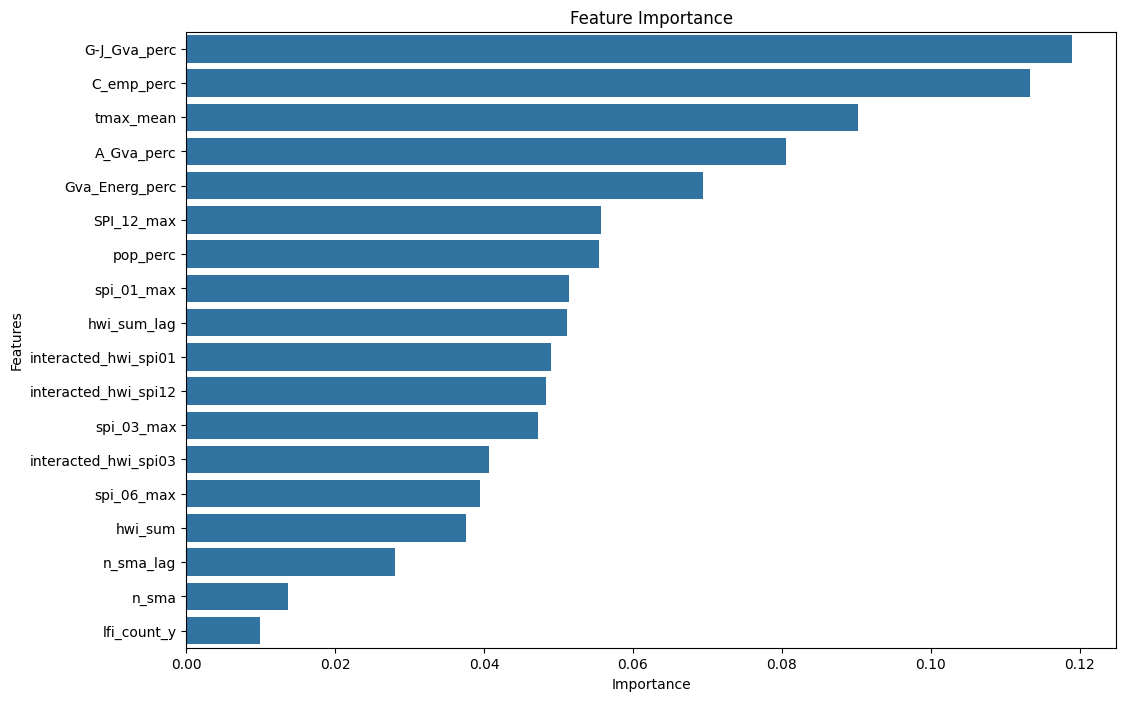

In [20]:
# Sort features according to importance
TOP_N = 20
feature_importance = feature_importance.sort_values('Importance', ascending=False)[:TOP_N]

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Validation (is all we need)

In [25]:
# Define the features and target
X_valid = df_valid.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y_valid = df_valid[TARGET]
# y_pred = best_model.predict(X_valid)

In [26]:
# Define the features and target
X_valid = df_valid.drop(TARGET, axis=1).drop(DROP_COLS, axis=1)
y_pred = best_model.predict(X_valid)

In [27]:
dfGva = pd.read_csv("dfGva.csv", index_col=0)
dfGva = dfGva[ (dfGva.year>=MIN_YEAR_TRAIN) & (dfGva.year<=MAX_YEAR_VALID) ]
dfGva

NUTS_ID  year   A_Gva  B-E_Gva    C_Gva  G-J_Gva  Gva_Energ  A_Gva_lag  \
1       AT111  2003   55.00   129.00    95.00   117.00      34.00      37.00   
2       AT111  2004   45.00   119.00    92.00   116.00      27.00      55.00   
3       AT111  2005   34.00   136.00   110.00   113.00      26.00      45.00   
4       AT111  2006   37.00   136.00   111.00   123.00      25.00      34.00   
5       AT111  2007   47.00   137.00   112.00   129.00      25.00      37.00   
...       ...   ...     ...      ...      ...      ...        ...        ...   
22441   SK042  2017  216.82  2350.20  2258.92  2444.02      91.28     194.54   
22442   SK042  2018  235.71  2597.97  2486.22  2458.81     111.75     216.82   
22443   SK042  2019  195.54  2651.68  2546.43  2642.94     105.25     235.71   
22444   SK042  2020  183.78  2463.48  2337.87  2663.64     125.61     195.54   
22445   SK042  2021  208.22  2958.89  2835.63  2861.08     123.26     183.78   

       A_Gva_perc  C_Gva_lag  C_Gva_perc  G-J_Gva_lag  G-J_Gva_perc  \
1        0.486486      92.00    0.032609       106.00      0.103774   
2       -0.181818      95.00   -0.031579       117.00     -0.008547   
3       -0.244444      92.00    0.195652       116.00     -0.025862   
4        0.088235     110.00    0.009091       113.00      0.088496   
5        0.270270     111.00    0.009009       123.00      0.048780   
...           ...        ...         ...          ...           ...   
22441    0.114527    2237.65    0.009506      2217.20      0.102300   
22442    0.087123    2258.92    0.100623      2444.02      0.006052   
22443   -0.170421    2486.22    0.024217      2458.81      0.074886   
22444   -0.060141    2546.43   -0.081903      2642.94      0.007832   
22445    0.132985    2337.87    0.212912      2663.64      0.074124   

       B-E_Gva_lag  B-E_Gva_perc  Gva_Energ_lag  Gva_Energ_perc  
1           117.00      0.102564          25.00        0.360000  
2           129.00     -0.077519          34.00       -0.205882  
3           119.00      0.142857          27.00       -0.037037  
4           136.00      0.000000          26.00       -0.038462  
5           136.00      0.007353          25.00        0.000000  
...            ...           ...            ...             ...  
22441      2335.41      0.006333          97.76       -0.066285  
22442      2350.20      0.105425          91.28        0.224255  
22443      2597.97      0.020674         111.75       -0.058166  
22444      2651.68     -0.070974         105.25        0.193444  
22445      2463.48      0.201102         125.61       -0.018709  

[21315 rows x 17 columns]

In [28]:
def return_gva(model, x_test, x_test_final, dfGva, segment):
    y_predict = model.predict(x_test)
    df_y_predict = pd.DataFrame(y_predict)
    df_y_predict.rename(columns = {0: "y_predict"}, inplace = True)
    x_test_return = pd.DataFrame(x_test)
    df = df_y_predict.merge(x_test_final, left_index = True, right_index = True)
    df = df.merge(x_test_final, left_index = True, right_index = True , how = 'outer')
    df = df.merge(dfGva, left_index = True, right_index = True , how = 'outer')
    df["Final_Prediction"] = df[segment+'_Gva_lag']*df['y_predict']+df[segment+'_Gva_lag']
    df = df[["NUTS_ID", 'Final_Prediction',"year"]]
    return df

In [29]:
result_gva = return_gva(best_model, X, X_valid, dfGva, "C")
result_gva = result_gva[ (result_gva.year>=MIN_YEAR_VALID) & (result_gva.year<=MAX_YEAR_VALID) ]

In [30]:
result = pd.DataFrame({'year': calculation_years, 'NUTS_ID': calculation_nuts, "Ind": result_gva.Final_Prediction})
result.to_csv("result_industry.csv")

In [32]:
result.to_csv("s3://ecb-hackathon-data-group04-x19s00/team_04_results/result_industry.csv")